In [21]:
#import

from whalegrad.nn.layers.activations import ReLU, sigmoid, tanh
from whalegrad.nn.layers.linear import Linear
from whalegrad.nn.loss import  SoftmaxCE
from whalegrad.nn.layers.model import Model
from whalegrad.nn.optim import Adam, Momentum, RMSProp, SGD
from whalegrad.engine.whalor import Whalor
from whalegrad.nn.layers.containers import Sequential
from whalegrad.engine.toolbox import grad_check
from whalegrad.nn.layers.essential import get_batches
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

In [22]:
# load data and split it into train and test sets

X, y = load_digits(return_X_y=True) # load data
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [23]:
num_train, num_test = X_train.shape[0], X_test.shape[0] # number of train and test examples
num_iter = 200 # number of iterations
batch_size = 200

In [24]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)


In [25]:
# Convert normalized inputs and targets to Tensor
X_train = Whalor(X_train_norm[:num_train,:].reshape(num_train,8,8))
X_test = Whalor(X_test_norm[:num_test,:].reshape(num_test,8,8))
y_train = Whalor(np.eye(10)[y_train[:num_train]])
y_test = Whalor(y_test[:num_test])

In [26]:
from whalegrad.nn.layers.convolutions import Conv2D

In [27]:
class CNN(Model):
    def __init__(self):
        self.layer1 = Conv2D((3,3))
        self.layer2 = ReLU()
        self.layer3 = Linear(36,10)
        
    def forward(self, inputs):
        conv_outputs = self.layer2(self.layer1(inputs))
        conv_outputs_flattened = conv_outputs.reshape((inputs.shape[0], 36))
        return self.layer3(conv_outputs_flattened)


In [28]:
# configure the model
model = CNN()
loss_fn = SoftmaxCE(axis=1)
optim = Adam(model.parameters(), 5e-3)

In [30]:
# train the Module
num_iter = 1000
for i in range(num_iter):
  for batch_input, batch_target in get_batches(X_train, y_train, batch_size):
    optim.zero_grad()
    outputs = model(batch_input)
    loss = loss_fn(outputs, batch_target)
    loss.backward()
    optim.step()
  if i%100==0:
    
      loss=loss,
      epoch=i
    
      print(f"iter {i+1}/{num_iter}\nloss: {loss}\n")

iter 1/1000
loss: (Whalor(12.727731140964034, requires_grad=True),)

iter 101/1000
loss: (Whalor(0.38149656466596515, requires_grad=True),)

iter 201/1000
loss: (Whalor(0.20130953358062703, requires_grad=True),)

iter 301/1000
loss: (Whalor(0.1088740618296509, requires_grad=True),)

iter 401/1000
loss: (Whalor(0.04178790159808233, requires_grad=True),)

iter 501/1000
loss: (Whalor(0.019816495384229853, requires_grad=True),)

iter 601/1000
loss: (Whalor(0.01058379381476349, requires_grad=True),)

iter 701/1000
loss: (Whalor(0.005623611705923364, requires_grad=True),)

iter 801/1000
loss: (Whalor(0.00308563641279938, requires_grad=True),)

iter 901/1000
loss: (Whalor(0.0017755185341874252, requires_grad=True),)



In [31]:
# Display a grid of digits
# num_rows>1 num_cols>1

def plt_digits(num_rows, num_cols, data, label, predicted=None, print_vals=True, figsize=(10,10), h_pad=1, w_pad=0.5):
  fig, axs = plt.subplots(num_rows, num_cols, figsize=figsize)
  assert (num_rows*num_cols<=data.shape[0]) and (num_rows*num_cols<=label.shape[0])
  if predicted is not None:
    assert (num_rows*num_cols<=predicted.shape[0])
  i=0
  for ax in axs:
    for j in range(num_cols):
      ax[j].imshow(data[i], cmap='gray')
      ax[j].axis('off')
      if predicted is not None:
          title = f'Actual: {label[i]}\nPredicted: {predicted[i]}'
      else:
          title = f'Actual: {label[i]}'
      if print_vals:
          ax[j].set_title(title,fontsize=8)
      i+=1
  fig.tight_layout(w_pad=w_pad,h_pad=h_pad)
  plt.show()

In [32]:
from whalegrad.nn.layers.activations import softmax

In [33]:
# evaluate the model
with model.eval():
  test_outputs = model(X_test)
  probs = softmax(1)(test_outputs.data)
  preds = np.argmax(probs.data, axis=1)

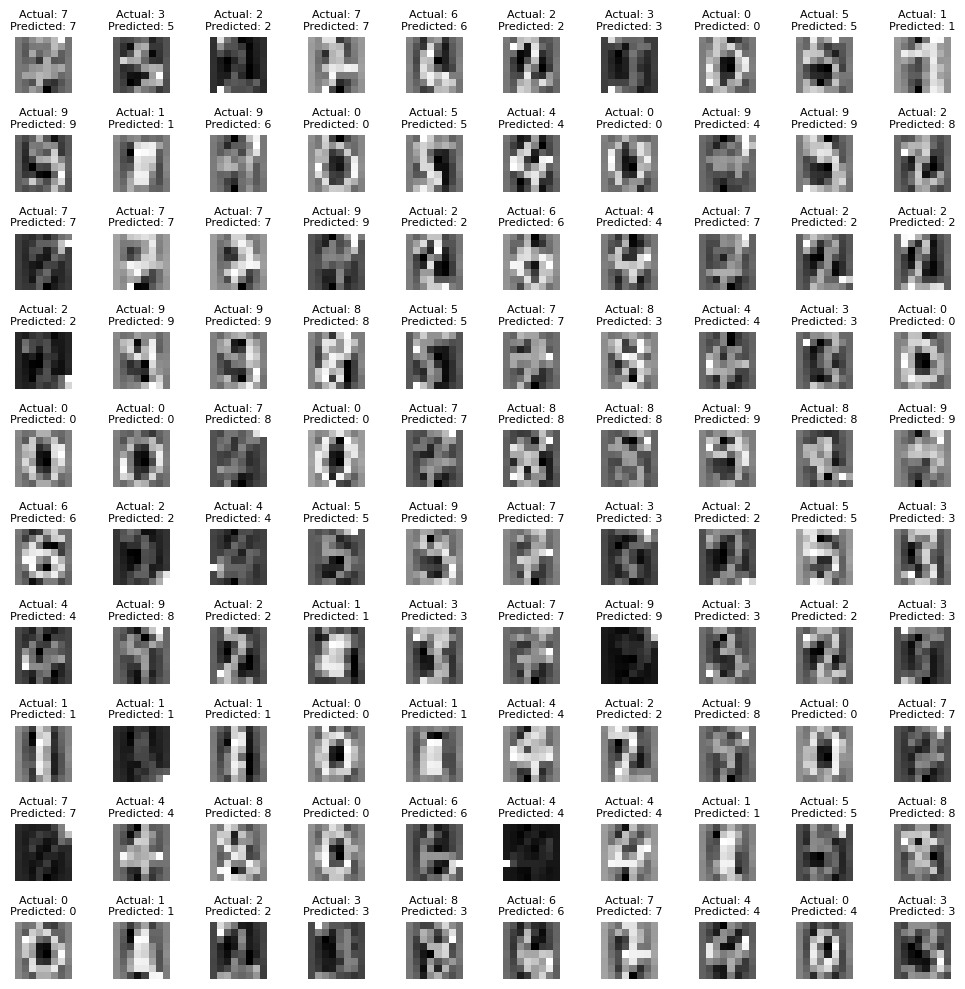

In [34]:
plt_digits(10,10,X_test.data,y_test.data.astype(int),preds)


In [35]:
# get report
report = classification_report(y_test.data.astype(int).flatten(), preds.flatten())
print(report)
accuracy = accuracy_score(y_test.data.astype(int).flatten(), preds.flatten())
print('Accuracy:', accuracy)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        51
           1       0.93      0.98      0.95        42
           2       1.00      0.93      0.96        43
           3       0.85      0.91      0.88        43
           4       0.95      0.91      0.93        43
           5       0.88      0.95      0.91        38
           6       0.91      0.95      0.93        42
           7       0.96      0.93      0.95        57
           8       0.80      0.85      0.82        39
           9       0.96      0.88      0.92        52

    accuracy                           0.93       450
   macro avg       0.92      0.93      0.92       450
weighted avg       0.93      0.93      0.93       450

Accuracy: 0.9266666666666666
